In [127]:
!pip install yahoofinancials mpld3 pyit2fls

In [454]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
%matplotlib inline
import mpld3
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from pyit2fls import IT2FS_Gaussian_UncertStd, crisp, IT2FS_plot

mpld3.enable_notebook()

# -----------------------------
# General Parameters
# -----------------------------
BATCH_SIZE = 20
SEQUENCE_LENGTH = 30
EPOCHS = 50
TRANSACTION_RATE = 0.005  # Transaction cost rate (0.5%)
PRICE_CHANGE_THRESHOLD = 0.01  # Threshold for generating buy/sell signals

In [456]:
end_date = datetime.today()
start_date = end_date - timedelta(days=15 * 365)
ticker = 'A17U.SI'
df = yf.download(ticker, start=start_date, end=end_date)

short_term_window_size = 20
long_term_window_size = 100

# Calculate the moving averages
df['Long_Term_Diff'] = df['Close'] - df['Close'].shift(long_term_window_size)

df['Short_Term_SMA'] = df['Close'].rolling(window = short_term_window_size, min_periods = 1).mean()
df['Long_Term_SMA'] = df['Close'].rolling(window = long_term_window_size, min_periods = 1).mean()

df = df.iloc[long_term_window_size:]

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Long_Term_Diff,Short_Term_SMA,Long_Term_SMA
Ticker,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,,,
Date,,,,,,,,,
2010-04-28 00:00:00+00:00,0.809414,1.855058,1.874585,1.825768,1.855058,9260028,-0.039054,1.911687,1.915397
2010-04-29 00:00:00+00:00,0.826454,1.894112,1.894112,1.864822,1.864822,5503167,0.019527,1.912663,1.915592
2010-04-30 00:00:00+00:00,0.826454,1.894112,1.913639,1.894112,1.894112,12370603,0.039054,1.912663,1.915982
2010-05-03 00:00:00+00:00,0.822194,1.884349,1.894112,1.864822,1.874585,3144374,0.039054,1.912663,1.916373
2010-05-04 00:00:00+00:00,0.817934,1.874585,1.894112,1.855058,1.894112,4321210,0.029290,1.911687,1.916666


In [458]:
##LSTM - Benchmark Model

In [460]:
short_term_window_size = 20
#mid_term_window_size = 30
long_term_window_size = 100

# 2. Prepare the Dataset with Selected Features
features = df[['Open', 'High', 'Low', 'Close',
               'Long_Term_Diff', 'Short_Term_SMA', 'Long_Term_SMA']]

# Normalize the data for stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [462]:
# 3. Create Sequences for LSTM Input
sequence_length = 30  # Use the last 30 days of data to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Last 30 days of features
    y.append(scaled_features[i, 0])  # Next day's closing price as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# 4. Split the Data into Training and Testing Sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# 5. Define the LSTM Model
def create_model(input_shape):
    model = tf.keras.Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')
    return model

model = create_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.7359 - val_loss: 0.1294
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.3392 - val_loss: 0.0641
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.2736 - val_loss: 0.0102
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.1989 - val_loss: 0.0615
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.1740 - val_loss: 0.0888
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.1540 - val_loss: 0.0721
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.1404 - val_loss: 0.0204
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1087 - val_loss: 0.0509
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1055 - val_loss: 0.0270
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0968 - val_loss: 0.0481
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0795 - val_loss: 0.0183
Epoch 12/50
164/164 ━━━━━━━━━━━━━━━━━━━━

In [343]:
# -----------------------------
# Transfer Learning for LSTM
# -----------------------------
# Save the trained weights
model.save_weights('lstm_model_weights.weights.h5')

# -----------------------------
# Data Preparation for J69U.SI
# -----------------------------
ticker_new = 'M44U.SI'
df_new = yf.download(ticker_new, start=start_date, end=end_date)

# Feature engineering (same as A17U.SI)
df_new['Long_Term_Diff'] = df_new['Close'] - df_new['Close'].shift(100)
df_new['Short_Term_SMA'] = df_new['Close'].rolling(window=20, min_periods=1).mean()
df_new['Long_Term_SMA'] = df_new['Close'].rolling(window=100, min_periods=1).mean()
df_new = df_new.iloc[100:]

features_new = df[['Open', 'High', 'Low', 'Close',
               'Long_Term_Diff', 'Short_Term_SMA', 'Long_Term_SMA']]

X_new, y_new = [], []
scaler_new = MinMaxScaler(feature_range=(0, 1))
scaled_features_new = scaler_new.fit_transform(features_new)

for i in range(SEQUENCE_LENGTH, len(scaled_features_new)):
    X_new.append(scaled_features_new[i - SEQUENCE_LENGTH:i])
    y_new.append(scaled_features_new[i, 3])

X_new, y_new = np.array(X_new), np.array(y_new)

train_size_new = int(len(X_new) * 0.9)
X_train_new, X_test_new = X_new[:train_size_new], X_new[train_size_new:]
y_train_new, y_test_new = y_new[:train_size_new], y_new[train_size_new:]

# Define and load the transfer learning model
transfer_lstm_model = create_model((X_train_new.shape[1], X_train_new.shape[2]))
transfer_lstm_model.load_weights('lstm_model_weights.weights.h5')

# Freeze lower layers and fine-tune
#for layer in transfer_lstm_model.layers[:-3]:
#    layer.trainable = False

transfer_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Train the transfer learning LSTM model
history_transfer_lstm = transfer_lstm_model.fit(
    X_train_new, y_train_new, 
    epochs=50, batch_size=20, 
    validation_data=(X_test_new, y_test_new)
)

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\User\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0014 - val_loss: 7.1961e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0016 - val_loss: 6.7966e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0014 - val_loss: 4.1251e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0015 - val_loss: 4.8591e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0013 - val_loss: 7.5796e-04
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 12/50
164/164 ━━━━━━━━━━━

In [272]:
#Fuzzy LSTM

#df[['Price_Diff', 'Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA']]
features_n_clusters = [6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3]

def clustering_features(features, features_n_clusters): #Get cluster centers, means and sigmas for each features given the number of clusters.

  cluster_centers = []
  cluster_means = []
  cluster_sigmas = []

  for i in range(scaled_features.shape[1]):

    n_clusters = features_n_clusters[i]
    feature_datas = scaled_features[:,i].reshape(-1, 1)

    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(feature_datas)

    centers = kmeans.cluster_centers_.flatten().tolist()
    labels = kmeans.labels_ #Calculate means and sigmas for each cluster

    means = []
    sigmas = []

    for i in range(n_clusters):
      cluster_points = feature_datas[labels == i]
      cluster_mean = np.mean(cluster_points)
      cluster_sigma = np.std(cluster_points)

      means.append(cluster_mean)
      sigmas.append(cluster_sigma)

    sorted_cluster_features = sorted(zip(centers, means, sigmas), key=lambda x: x[0])
    centers, means, sigmas = map(list, zip(*sorted_cluster_features))


    cluster_centers.append(centers)
    cluster_means.append(means)
    cluster_sigmas.append(sigmas)


  return cluster_centers, cluster_means, cluster_sigmas


def generate_it2fmf(cluster_means, cluster_sigmas):

  num_features = len(cluster_means)
  it2fmf = []
  for i in range(num_features):
    feature_cluster_means = cluster_means[i]
    feature_cluster_sigmas = cluster_sigmas[i]
    feature_fmf_list = []

    for j in range(len(feature_cluster_means)):
      cluster_mean = feature_cluster_means[j]
      cluster_sigma = feature_cluster_sigmas[j]

      fmf = IT2FS_Gaussian_UncertStd((0, 1), [cluster_mean, cluster_sigma, cluster_sigma/2, 1.])
      feature_fmf_list.append(fmf)
    it2fmf.append(feature_fmf_list)
  return it2fmf


cluster_centers, cluster_means, cluster_sigmas = clustering_features(scaled_features, features_n_clusters)
it2fmf = generate_it2fmf(cluster_means, cluster_sigmas)

In [273]:
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, it2fmf):
        """
        Custom Fuzzy Layer.
        Parameters:
        - it2fmf: List of fuzzy membership functions for each feature.
        """
        super(FuzzyLayer, self).__init__()
        self.it2fmf = it2fmf  # Precomputed fuzzy membership functions
        self.fmf_count = 0
        for feature_fmf_list in it2fmf:
            self.fmf_count += len(feature_fmf_list)

    def call(self, inputs):
        """
        Compute fuzzy membership degrees for the input features.
        Parameters:
        - inputs: Input tensor of shape (batch_size, num_features).
        Returns:
        - fuzzified_inputs: Tensor of shape (batch_size, num_features, num_memberships).
        """
        feature_membership_values = []
        for i, feature_fmf_list in enumerate(self.it2fmf):
            feature_values = inputs[:, :, i:i+1]  # Extract the i-th feature (shape: batch_size, 1)
            # Compute fuzzy membership degrees for each fuzzy set in the feature
            for fmf in feature_fmf_list:
                # Compute the upper and lower membership degrees
                umf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.umf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                lmf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.lmf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                feature_membership_values.append(tf.squeeze(umf_values, axis=2))
                feature_membership_values.append(tf.squeeze(lmf_values, axis=2))
        stacked_membership_values = tf.stack(feature_membership_values, axis=0)
        fuzzified_inputs = tf.transpose(stacked_membership_values, perm=[1, 2, 0])
        fuzzified_inputs = tf.reshape(fuzzified_inputs, (-1, inputs.shape[1], self.fmf_count * 2))
        #fuzzified_inputs = tf.concat([inputs[:, :, 0:1], fuzzified_inputs], axis=-1)

        return fuzzified_inputs



In [274]:
fuzzy_layer = FuzzyLayer(it2fmf)

# -----------------------------
# Fuzzy LSTM Model
# -----------------------------
def create_fuzzy_model(input_shape, fuzzy_layer):
    model = tf.keras.Sequential([
        fuzzy_layer,
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the fuzzy LSTM model
fuzzy_model = create_fuzzy_model((X_train.shape[1], X_train.shape[2]), fuzzy_layer)
history_fuzzy = fuzzy_model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - loss: 0.7637 - val_loss: 0.0476
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 0.1417 - val_loss: 0.0097
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - loss: 0.0762 - val_loss: 0.0062
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - loss: 0.0475 - val_loss: 0.0056
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0377 - val_loss: 0.0063
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - loss: 0.0272 - val_loss: 0.0077
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0223 - val_loss: 0.0192
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - loss: 0.0175 - val_loss: 0.0099
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - loss: 0.0140 - val_loss: 0.0079
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 0.0114 - val_loss: 0.0095
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - loss: 0.0122 - val_loss: 0.0025
Epoch 12/50
164/164

In [275]:
# Save the trained weights for transfer learning
fuzzy_model.save_weights('flstm_model_weights.weights.h5')

In [276]:
# ----------------------------------------
# 6. Transfer Learning for FLSTM Model on J69U.SI
# ----------------------------------------
# Compute cluster centers and generate fuzzy membership functions for J69U.SI
cluster_centers_new, cluster_means_new, cluster_sigmas_new = clustering_features(scaled_features_new, features_n_clusters)
it2fmf_new = generate_it2fmf(cluster_means_new, cluster_sigmas_new)

# Define a new fuzzy layer for transfer learning
fuzzy_layer_new = FuzzyLayer(it2fmf_new)

# Define the transfer learning Fuzzy LSTM model
transfer_fuzzy_model = create_fuzzy_model((X_train_new.shape[1], X_train_new.shape[2]), fuzzy_layer_new)

# Explicitly build the model to initialize all layers
transfer_fuzzy_model.build(input_shape=(None, X_train_new.shape[1], X_train_new.shape[2]))

# Load the pre-trained weights
transfer_fuzzy_model.load_weights('flstm_model_weights.weights.h5')

# Fine-tune by freezing initial layers
for layer in transfer_fuzzy_model.layers[:-2]:
    layer.trainable = False

# Compile the transfer learning FLSTM model
transfer_fuzzy_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the transfer learning FLSTM model
history_transfer_fuzzy = transfer_fuzzy_model.fit(
    X_train_new, y_train_new,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(X_test_new, y_test_new)
)

Epoch 1/50


C:\Users\User\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - loss: 0.0105 - val_loss: 5.0207e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - loss: 0.0065 - val_loss: 8.1667e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - loss: 0.0061 - val_loss: 3.3496e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - loss: 0.0056 - val_loss: 3.1430e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - loss: 0.0058 - val_loss: 3.0962e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - loss: 0.0055 - val_loss: 6.4862e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - loss: 0.0053 - val_loss: 2.6026e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - loss: 0.0051 - val_loss: 2.1006e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0054 - val_loss: 2.9034e-04
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0058 - val_loss: 2.8745e-04
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 0.0060 - val_los

In [431]:
# 7. Make Predictions
# Predict with transfer LSTM model
y_pred_LSTM = model.predict(X_test_new)
# Predict with transfer FLSTM model
#y_pred_transfer_FLSTM = transfer_fuzzy_model.predict(X_test_new)

# Inverse transform predictions to original scale
def inverse_transform_predictions(y_pred_scaled, scaler, num_features):
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((np.zeros((y_pred_scaled.shape[0], num_features - 1)), y_pred_scaled), axis=1)
    )[:, -1]  # Assuming the target variable is at the last position
    return y_pred_rescaled

num_features_new = scaled_features_new.shape[1]
y_pred_rescaled_LSTM = inverse_transform_predictions(y_pred_LSTM, scaler_new, num_features_new)
#y_pred_rescaled_transfer_FLSTM = inverse_transform_predictions(y_pred_transfer_FLSTM, scaler_new, num_features_new)
y_test_rescaled = inverse_transform_predictions(y_test_new.reshape(-1, 1), scaler_new, num_features_new)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [433]:
def calculate_transaction_signals(predicted_price, actual_price, price_change_threshold):
  # predicted_price: Rescaled predicted stock price
  # actual_price: Actual stock price
  # price_change_threshold: Set a minimum price change threshold to filter minor fluctuations
  buy_signals, sell_signals = [], []

  for i in range(1, len(predicted_price)):
    price_diff = predicted_price[i] - predicted_price[i - 1]   #was predicted_price[i] - actual_price[i - 1]
    if price_diff > price_change_threshold:  # Significant increase
        buy_signals.append(predicted_price[i])
        sell_signals.append(np.nan)
    elif price_diff < -price_change_threshold:  # Significant decrease
        sell_signals.append(predicted_price[i])
        buy_signals.append(np.nan)
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)
  return buy_signals, sell_signals

In [435]:
def calculate_portfolio(buy_signals, sell_signals, actual_price, transaction_rate):


  actions = np.zeros(len(actual_price))
  for i in range(0, len(actions)-1):
      if not np.isnan(buy_signals[i]):
          actions[i] = 1  # Buy
      elif not np.isnan(sell_signals[i]):
          actions[i] = -1  # Sell
      else:
          actions[i] = 0  # Hold

  # Calculate portfolio returns based on Equation (1)
  portfolio = [1.0]  # Starting portfolio returns at 1.0 for cumulative product calculation
  for i in range(1, len(actual_price)):
      r_t = (actual_price[i] / actual_price[i - 1]) - 1  # Return rate
      action_change = abs(actions[i] - actions[i - 1])  # Change in action to capture transaction cost
      R_t = (1 + actions[i - 1] * r_t) * (1 - transaction_rate * action_change)
      portfolio.append(portfolio[-1] * R_t)
  return portfolio

In [437]:
# Caluclate LSTM Portfolio Returns

transaction_rate = 0.005  # Transaction cost rate (0.5%)

price_change_threshold = 0.01

LSTM_pred_buy_signals, LSTM_pred_sell_signals = calculate_transaction_signals(y_pred_rescaled_LSTM, y_test_rescaled, price_change_threshold)
LSTM_pred_portfolio = calculate_portfolio(LSTM_pred_buy_signals, LSTM_pred_sell_signals, y_test_rescaled, transaction_rate)

#FLSTM_pred_buy_signals, FLSTM_pred_sell_signals = calculate_transaction_signals(y_pred_rescaled_FLSTM, y_test_rescaled, price_change_threshold)
#FLSTM_pred_portfolio = calculate_portfolio(FLSTM_pred_buy_signals, FLSTM_pred_sell_signals, y_test_rescaled, transaction_rate)

# Caluclate baseline buy and sell signals

df['Signal'] = np.where(df['Long_Term_SMA'] > df['Short_Term_SMA'], 1.0, 0.0)

baseline_signals = np.array(df['Signal'].diff())
baseline_signals[0] = 0
baseline_signals = baseline_signals[-len(y_test)+1:]

baseline_buy_signals, baseline_sell_signals = [], []

for i in range(0, len(baseline_signals)):
    if baseline_signals[i] == 1:
        baseline_buy_signals.append(y_test_rescaled[i])
        baseline_sell_signals.append(np.nan)
    elif baseline_signals[i] == -1:
        baseline_sell_signals.append(y_test_rescaled[i])
        baseline_buy_signals.append(np.nan)
    else:
        baseline_buy_signals.append(np.nan)
        baseline_sell_signals.append(np.nan)

baseline_portfolio = calculate_portfolio(baseline_buy_signals, baseline_sell_signals, y_test_rescaled, transaction_rate)



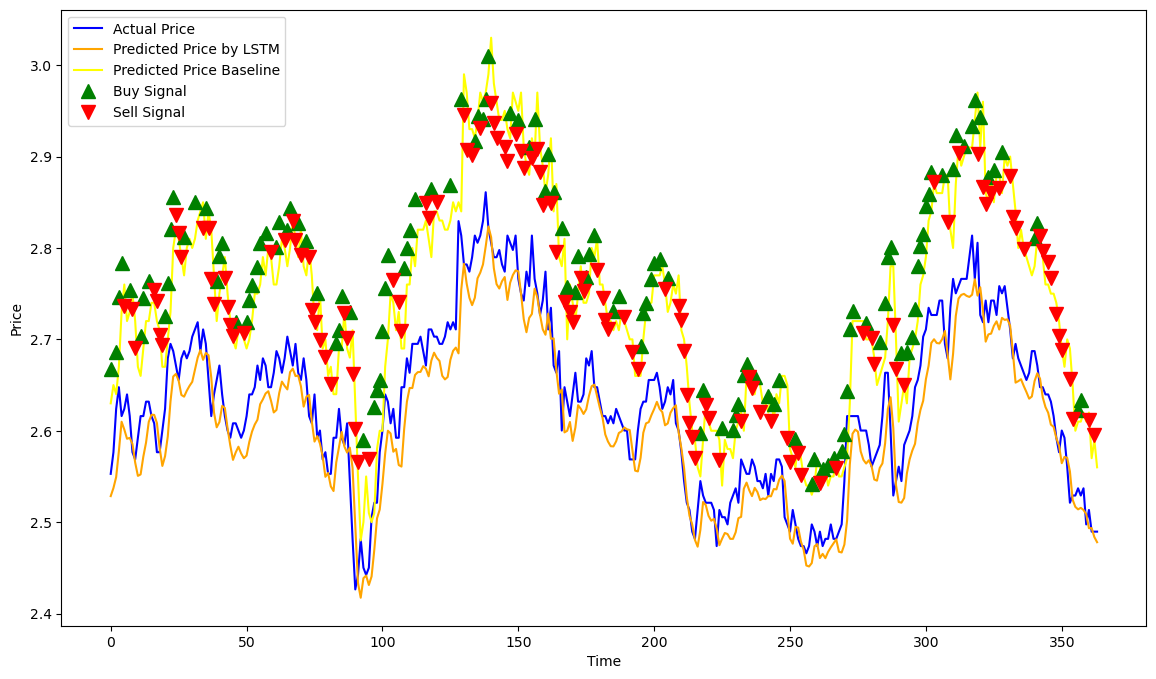

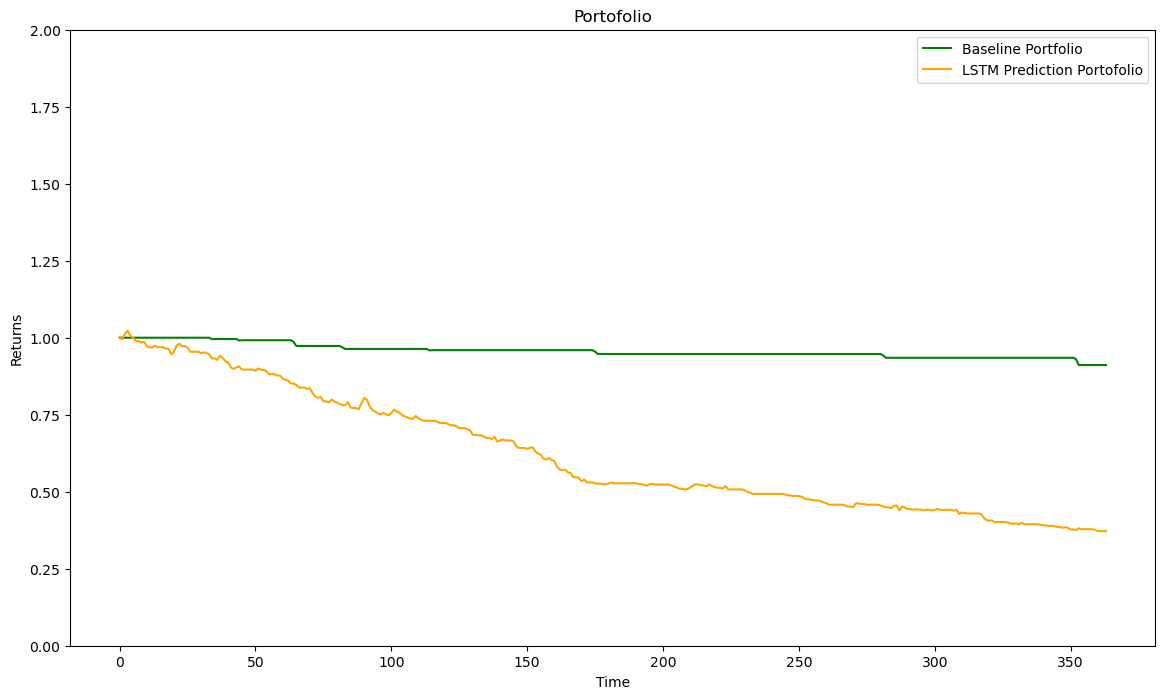

Final portofolio for baseline:  0.9112396677937893
Final portofolio for LSTM prediction:  0.3721392076251276


In [439]:
# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled_LSTM, label='Predicted Price by LSTM', color='orange')
#plt.plot(y_pred_rescaled_FLSTM, label='Predicted Price by Fuzzy LSTM', color='purple')
plt.plot(y_pred_baseline, label='Predicted Price Baseline', color='yellow')

plt.plot(FLSTM_pred_buy_signals, marker='^', markersize=10, color='green', linestyle='None', label='Buy Signal')
plt.plot(FLSTM_pred_sell_signals, marker='v', markersize=10, color='red', linestyle='None', label='Sell Signal')
#plt.title('LSTM and FLSTM Model - Actual vs Predicted Stock Price with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.ylim((0, 2))
plt.plot(baseline_portfolio, label='Baseline Portfolio', color='green')
plt.plot(LSTM_pred_portfolio, label='LSTM Prediction Portofolio', color='orange')
#plt.plot(FLSTM_pred_portfolio, label='FLSTM Prediction Portofolio', color='purple')
plt.title('Portofolio')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

print("Final portofolio for baseline: ", baseline_portfolio[-1])

#print("Final portofolio for FLSTM prediction: ", FLSTM_pred_portfolio[-1])
print("Final portofolio for LSTM prediction: ", LSTM_pred_portfolio[-1])

In [282]:
transfer_lstm_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                       │ (None, 30, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_50 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_51 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,037 (531.40 KB)

 Trainable params: 545 (2.13 KB)

 Non-trainable params: 134,400 (525.00 KB)

 Optimizer params: 1,092 (4.27 KB)

In [283]:
transfer_fuzzy_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fuzzy_layer_13 (FuzzyLayer)          │ (None, 30, 120)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_55 (LSTM)                       │ (None, 30, 128)             │         127,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_56 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_57 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,845 (749.40 KB)

 Trainable params: 545 (2.13 KB)

 Non-trainable params: 190,208 (743.00 KB)

 Optimizer params: 1,092 (4.27 KB)

In [151]:

#Transfer Learning

'''
#Prepare data for new stock

end_date = datetime.today()
start_date = end_date - timedelta(days=3 * 365)
ticker = 'J69U.SI'
df2 = yf.download(ticker, start=start_date, end=end_date)
df2.head()


df2['Price_Diff'] = df2['Close'].diff()
df['Volatility'] = df2['Close'].rolling(window=10).std()

df2['LSTM_Fast_SMA'] = df2['Close'].rolling(window = 7, min_periods = 1).mean()
df2['LSTM_Slow_SMA'] = df2['Close'].rolling(window = 30, min_periods = 1).mean()

df2['Fast_SMA'] = df2['Close'].rolling(window = 20, min_periods = 1).mean()
df2['Slow_SMA'] = df2['Close'].rolling(window = 100, min_periods = 1).mean()

# Drop any rows with NaN values (resulting from the rolling window and differencing)
df2.dropna(inplace=True)

# 2. Prepare the Dataset with Selected Features
features_new = df2[['Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA', 'Price_Diff']]

# Normalize the data for stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

cluster_centers, cluster_means, cluster_sigmas = clustering_features(scaled_features, features_n_clusters)
it2fmf = generate_it2fmf(cluster_means, cluster_sigmas)


# Split the new dataset into training and testing sets
sequence_length = 30  # Use the last 30 days of data to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Last 30 days of features
    y.append(scaled_features[i, 0])  # Next day's closing price as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# 4. Split the Data into Training and Testing Sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


fuzzy_model.save_weights('fuzzy_model.weights.h5')

fuzzy_layer_new = FuzzyLayer(it2fmf)  # Use the new fuzzy sets generated for 'A179.SI'

transfer_model = tf.keras.Sequential([
    fuzzy_layer_new,  # Use a new fuzzy layer specific to the new stock
    tf.keras.layers.LSTM(16, return_sequences=True, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, trainable=False),  # Freeze Dense layers
    tf.keras.layers.LSTM(16, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dense(1)  # Output layer remains trainable
])

# Load the weights from the pretrained model
transfer_model.load_weights('fuzzy_model.weights.h5')

transfer_model.compile(optimizer='adam', loss='mean_squared_error')

history = transfer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# New model without saved weights

new_model = tf.keras.Sequential([
    fuzzy_layer_new,  # Use a new fuzzy layer specific to the new stock
    tf.keras.layers.LSTM(16, return_sequences=True, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, trainable=False),  # Freeze Dense layers
    tf.keras.layers.LSTM(16, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dense(1)  # Output layer remains trainable
])

new_model.compile(optimizer='adam', loss='mean_squared_error')
history = new_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
'''

"\n#Prepare data for new stock\n\nend_date = datetime.today()\nstart_date = end_date - timedelta(days=3 * 365)\nticker = 'J69U.SI'\ndf2 = yf.download(ticker, start=start_date, end=end_date)\ndf2.head()\n\n\ndf2['Price_Diff'] = df2['Close'].diff()\ndf['Volatility'] = df2['Close'].rolling(window=10).std()\n\ndf2['LSTM_Fast_SMA'] = df2['Close'].rolling(window = 7, min_periods = 1).mean()\ndf2['LSTM_Slow_SMA'] = df2['Close'].rolling(window = 30, min_periods = 1).mean()\n\ndf2['Fast_SMA'] = df2['Close'].rolling(window = 20, min_periods = 1).mean()\ndf2['Slow_SMA'] = df2['Close'].rolling(window = 100, min_periods = 1).mean()\n\n# Drop any rows with NaN values (resulting from the rolling window and differencing)\ndf2.dropna(inplace=True)\n\n# 2. Prepare the Dataset with Selected Features\nfeatures_new = df2[['Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA', 'Price_Diff']]\n\n# Normalize the data for stability\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled_features = scaler.fit_transform(featur

In [17]:
'''
y_pred_transfer = transfer_model.predict(X_test)
y_pred_new = new_model.predict(X_test)


price_change_threshold = 0.001

transfer_pred_buy_signals, transfer_pred_sell_signals = calculate_transaction_signals(y_pred_transfer, y_test_rescaled, price_change_threshold)
transfer_pred_portfolio = calculate_portfolio(transfer_pred_buy_signals, transfer_pred_sell_signals, y_test_rescaled, transaction_rate)

new_pred_buy_signals, new_pred_sell_signals = calculate_transaction_signals(y_pred_new, y_test_rescaled, price_change_threshold)
new_pred_portfolio = calculate_portfolio(new_pred_buy_signals, new_pred_sell_signals, y_test_rescaled, transaction_rate)

plt.figure(figsize=(14, 8))
plt.ylim((0, 1.5))

plt.plot(transfer_pred_portfolio, label='Transfer Learning Prediction Portofolio', color='orange')
plt.plot(new_pred_portfolio, label='New Model Prediction Portofolio', color='purple')
plt.title('Portofolio')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

print("Final portofolio for baseline: ", baseline_portfolio[-1])

print("Final portofolio for transfer learning prediction: ", transfer_pred_portfolio[-1])
print("Final portofolio for new model prediction: ", new_pred_portfolio[-1])
'''

'\ny_pred_transfer = transfer_model.predict(X_test)\ny_pred_new = new_model.predict(X_test)\n\n\nprice_change_threshold = 0.001\n\ntransfer_pred_buy_signals, transfer_pred_sell_signals = calculate_transaction_signals(y_pred_transfer, y_test_rescaled, price_change_threshold)\ntransfer_pred_portfolio = calculate_portfolio(transfer_pred_buy_signals, transfer_pred_sell_signals, y_test_rescaled, transaction_rate)\n\nnew_pred_buy_signals, new_pred_sell_signals = calculate_transaction_signals(y_pred_new, y_test_rescaled, price_change_threshold)\nnew_pred_portfolio = calculate_portfolio(new_pred_buy_signals, new_pred_sell_signals, y_test_rescaled, transaction_rate)\n\nplt.figure(figsize=(14, 8))\nplt.ylim((0, 1.5))\n\nplt.plot(transfer_pred_portfolio, label=\'Transfer Learning Prediction Portofolio\', color=\'orange\')\nplt.plot(new_pred_portfolio, label=\'New Model Prediction Portofolio\', color=\'purple\')\nplt.title(\'Portofolio\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'Returns\')\nplt.legend(